<a href="https://colab.research.google.com/github/s-ravi18/HAR/blob/main/X_Shaped_AutoEncoder_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, concatenate, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold

In [3]:
### Label Encoding, Removing Zero variance Features and Scaling the test data::
def initial(df):
    
    #### Label Encoding the Target Variable
    X=df.drop(["label"],axis=1)
    y=df["label"]
    if df.label.dtype==str:   ### Will apply label encoding if needed
        le=LabelEncoder()
        y=le.fit_transform(y)
        y=pd.Series(y)

    #### Removing Features having zero variance.

    Var=X[X.columns].std()
    col=Var[Var==0].index
    X=X.drop(col,axis=1)
    
    return X,y

In [4]:
def preprocess():
  ### For the best model using EMG and NEMG Features (EMG+NEMG Combined)
  df_emg=pd.read_csv("/content/drive/MyDrive/HAR Datasets/EMG_ANOVA_200_features.csv").rename({'0':'label'},axis=1)
  df_nemg=pd.read_csv("/content/drive/MyDrive/HAR Datasets/NEMG_ANOVA_200_features.csv").rename({"0":"label"},axis=1)

  # temp=pd.DataFrame()
  # for i in range(26):
  #     n=df_nemg[df_nemg["label"]==i].reset_index(drop=True)
  #     e=df_emg[df_emg["label"]==i].reset_index(drop=True).drop(["label"],axis=1)[0:n.shape[0]]
  #     k=pd.concat([e,n],axis=1)
  #     temp=pd.concat([temp,k],axis=0)   

  X1,y1=initial(df_emg) 
  X2,y2=initial(df_nemg)

  l1=list(df_emg.columns[:-1])
  l2=list(df_nemg.columns[:-1])

  ## Splitting the EMG data:
  X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,stratify=y1,test_size=0.15, random_state=2)
  sc=StandardScaler()
  X_train1=sc.fit_transform(X_train1)
  X_train1=pd.DataFrame(X_train1,columns=l1)
  X_test1=sc.transform(X_test1)
  X_test1=pd.DataFrame(X_test1,columns=l1)

  ## Splitting the IMU data:
  X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y1,stratify=y1,test_size=0.15, random_state=2)
  sc=StandardScaler()
  X_train2=sc.fit_transform(X_train2)
  X_train2=pd.DataFrame(X_train2,columns=l2)
  X_test2=sc.transform(X_test2)
  X_test2=pd.DataFrame(X_test2,columns=l2)

  m=min(X1.shape[0],X2.shape[0])

  return X1.iloc[:m,:],X2.iloc[:m,:]

In [5]:
## Model Building:
class model:
  def __init__(self,emg_shape,imu_shape,decoder=False):
    # Define the input shape for each sensor feature
    input_shape1 = (emg_shape,)  # Sensor 1 has 100 features
    input_shape2 = (imu_shape,)   # Sensor 2 has 50 features

    # Define the first encoder layer for each sensor input
    input_layer1 = Input(shape=input_shape1)
    hidden_layer1_1 = Dense(64, activation='relu')(input_layer1)

    input_layer2 = Input(shape=input_shape2)
    hidden_layer2_1 = Dense(32, activation='relu')(input_layer2)

    # Define the second encoder layer for each sensor input
    hidden_layer1_2 = Dense(32, activation='relu')(hidden_layer1_1)
    hidden_layer2_2 = Dense(16, activation='relu')(hidden_layer2_1)

    # Combine the encoder outputs from each sensor input
    merged_encoder_output = concatenate([hidden_layer1_2, hidden_layer2_2], axis=-1)
    
    if decoder==True:
      # Define the shared decoder layers
      hidden_layer3 = Dense(16, activation='relu')(merged_encoder_output)
      hidden_layer4 = Dense(32, activation='relu')(hidden_layer3)

      # Define the decoder layer for each sensor input
      output_layer1 = Dense(emg_shape, activation='sigmoid')(hidden_layer4)
      output_layer2 = Dense(imu_shape, activation='sigmoid')(hidden_layer4)

      # Define the autoencoder model with multiple inputs and outputs
      self.autoencoder = tf.keras.models.Model(inputs=[input_layer1, input_layer2], outputs=[output_layer1, output_layer2])
    else:
      self.autoencoder = tf.keras.models.Model(inputs=[input_layer1, input_layer2], outputs=merged_encoder_output)

  def model_config(self):
    self.autoencoder.compile(optimizer=Adam(lr=0.001),metrics='accuracy',loss='mse')
    return self.autoencoder

In [6]:
X1,X2=preprocess()

In [ ]:
def lc(path,loss,val_loss):
  plt.figure(figsize=(10,10))
  plt.plot(loss,c= 'b',label="train_loss")
  plt.plot(val_loss,c= 'r',label="val_loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(f"{path}/learning_curve.png")

In [ ]:
def train(path,X1,X2):
  if os.path.exists(f'{path}') == False:
    os.mkdir(f'{path}')

  #---
  sc1=StandardScaler()
  X1=sc1.fit_transform(X1)
  #---
  sc2=StandardScaler()
  X2=sc2.fit_transform(X2)

  n_split=5
  sf=KFold(n_split)
  emg=list(sf.split(X1))
  imu=list(sf.split(X2))
  results={}

  for i in range(n_split):
    autoencoder=model(X1.shape[1],X2.shape[1],True).model_config()
    history = autoencoder.fit([X1[[emg[i][0]]],X2[[imu[i][0]]]], [X1[[emg[i][0]]],X2[[imu[i][0]]]], epochs=100, batch_size=50,
                                  validation_data=([X1[[emg[i][1]]],X2[[imu[i][1]]]],[X1[[emg[i][1]]],X2[[imu[i][1]]]]))

    lc(path,history.history["loss"],history.history["val_loss"])
    # results[f"Fold {i+1}"]={"output_imu_accuracy":max(history.history['output_imu_accuracy']),
    #                   "val_output_imu_accuracy":max(history.history['val_output_imu_accuracy']),
    #                   "output_emg_accuracy":max(history.history['output_emg_accuracy']),
    #                   "val_output_emg_accuracy":max(history.history['val_output_emg_accuracy'])}

  with open(f'{path}/results.json', 'w') as fp:
    json.dump(results, fp,  indent=4)
  encoder=model(X1.shape[1],X2.shape[1],False).model_config()
  encoder.save(f"{path}/model.h5")

<ipython-input-22-a50fdb5b95e3>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  history = autoencoder.fit([X1[[emg[i][0]]],X2[[imu[i][0]]]], [X1[[emg[i][0]]],X2[[imu[i][0]]]], epochs=100, batch_size=50,
<ipython-input-22-a50fdb5b95e3>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  validation_data=([X1[[emg[i][1]]],X2[[imu[i][1]]]],[X1[[emg[i][1]]],X2[[imu[i][1]]]]))


Epoch 1/100
379/379 [==============================] - 3s 3ms/step - loss: 1.5744 - dense_30_loss: 0.8398 - dense_31_loss: 0.7347 - dense_30_accuracy: 0.0299 - dense_31_accuracy: 0.0249 - val_loss: 0.8790 - val_dense_30_loss: 0.4834 - val_dense_31_loss: 0.3956 - val_dense_30_accuracy: 0.0222 - val_dense_31_accuracy: 0.0013
Epoch 2/100
379/379 [==============================] - 1s 3ms/step - loss: 1.3744 - dense_30_loss: 0.7361 - dense_31_loss: 0.6383 - dense_30_accuracy: 0.0438 - dense_31_accuracy: 0.0889 - val_loss: 0.7937 - val_dense_30_loss: 0.4191 - val_dense_31_loss: 0.3746 - val_dense_30_accuracy: 0.0296 - val_dense_31_accuracy: 0.1189
Epoch 3/100
379/379 [==============================] - 1s 3ms/step - loss: 1.3545 - dense_30_loss: 0.7220 - dense_31_loss: 0.6325 - dense_30_accuracy: 0.0685 - dense_31_accuracy: 0.1290 - val_loss: 0.7788 - val_dense_30_loss: 0.4066 - val_dense_31_loss: 0.3722 - val_dense_30_accuracy: 0.0260 - val_dense_31_accuracy: 0.0866
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 3s 4ms/step - loss: 1.4377 - dense_38_loss: 0.7384 - dense_39_loss: 0.6992 - dense_38_accuracy: 0.0176 - dense_39_accuracy: 0.0068 - val_loss: 1.4297 - val_dense_38_loss: 0.9153 - val_dense_39_loss: 0.5144 - val_dense_38_accuracy: 0.0310 - val_dense_39_accuracy: 0.0353
Epoch 2/100
379/379 [==============================] - 1s 3ms/step - loss: 1.2459 - dense_38_loss: 0.6351 - dense_39_loss: 0.6108 - dense_38_accuracy: 0.0405 - dense_39_accuracy: 0.0511 - val_loss: 1.3932 - val_dense_38_loss: 0.8883 - val_dense_39_loss: 0.5050 - val_dense_38_accuracy: 0.0374 - val_dense_39_accuracy: 0.1434
Epoch 3/100
379/379 [==============================] - 1s 3ms/step - loss: 1.2198 - dense_38_loss: 0.6257 - dense_39_loss: 0.5941 - dense_38_accuracy: 0.0504 - dense_39_accuracy: 0.0822 - val_loss: 1.3704 - val_dense_38_loss: 0.8719 - val_dense_39_loss: 0.4985 - val_dense_38_accuracy: 0.0260 - val_dense_39_accuracy: 0.1712
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 3s 3ms/step - loss: 1.4225 - dense_46_loss: 0.7390 - dense_47_loss: 0.6835 - dense_46_accuracy: 0.0231 - dense_47_accuracy: 0.0251 - val_loss: 1.6238 - val_dense_46_loss: 0.8936 - val_dense_47_loss: 0.7302 - val_dense_46_accuracy: 0.0304 - val_dense_47_accuracy: 0.0239
Epoch 2/100
379/379 [==============================] - 1s 3ms/step - loss: 1.2216 - dense_46_loss: 0.6278 - dense_47_loss: 0.5938 - dense_46_accuracy: 0.0497 - dense_47_accuracy: 0.0826 - val_loss: 1.5567 - val_dense_46_loss: 0.8432 - val_dense_47_loss: 0.7135 - val_dense_46_accuracy: 0.0262 - val_dense_47_accuracy: 0.0230
Epoch 3/100
379/379 [==============================] - 1s 3ms/step - loss: 1.2054 - dense_46_loss: 0.6157 - dense_47_loss: 0.5897 - dense_46_accuracy: 0.0623 - dense_47_accuracy: 0.1042 - val_loss: 1.5337 - val_dense_46_loss: 0.8295 - val_dense_47_loss: 0.7041 - val_dense_46_accuracy: 0.0234 - val_dense_47_accuracy: 0.0353
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 3s 3ms/step - loss: 1.4163 - dense_54_loss: 0.8178 - dense_55_loss: 0.5985 - dense_54_accuracy: 0.0474 - dense_55_accuracy: 0.0108 - val_loss: 1.6044 - val_dense_54_loss: 0.6253 - val_dense_55_loss: 0.9791 - val_dense_54_accuracy: 0.0467 - val_dense_55_accuracy: 0.0139
Epoch 2/100
379/379 [==============================] - 1s 3ms/step - loss: 1.2329 - dense_54_loss: 0.7061 - dense_55_loss: 0.5268 - dense_54_accuracy: 0.0675 - dense_55_accuracy: 0.0733 - val_loss: 1.5585 - val_dense_54_loss: 0.5901 - val_dense_55_loss: 0.9685 - val_dense_54_accuracy: 0.0496 - val_dense_55_accuracy: 0.0500
Epoch 3/100
379/379 [==============================] - 1s 3ms/step - loss: 1.2093 - dense_54_loss: 0.6942 - dense_55_loss: 0.5151 - dense_54_accuracy: 0.0617 - dense_55_accuracy: 0.1272 - val_loss: 1.4985 - val_dense_54_loss: 0.5616 - val_dense_55_loss: 0.9369 - val_dense_54_accuracy: 0.0477 - val_dense_55_accuracy: 0.0492
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 3s 4ms/step - loss: 1.4404 - dense_62_loss: 0.7428 - dense_63_loss: 0.6976 - dense_62_accuracy: 0.0430 - dense_63_accuracy: 0.0073 - val_loss: 1.5288 - val_dense_62_loss: 0.9318 - val_dense_63_loss: 0.5970 - val_dense_62_accuracy: 0.0118 - val_dense_63_accuracy: 0.0019
Epoch 2/100
379/379 [==============================] - 1s 4ms/step - loss: 1.2140 - dense_62_loss: 0.6167 - dense_63_loss: 0.5973 - dense_62_accuracy: 0.0983 - dense_63_accuracy: 0.0327 - val_loss: 1.4467 - val_dense_62_loss: 0.8647 - val_dense_63_loss: 0.5820 - val_dense_62_accuracy: 0.0230 - val_dense_63_accuracy: 0.0089
Epoch 3/100
379/379 [==============================] - 2s 4ms/step - loss: 1.1986 - dense_62_loss: 0.6037 - dense_63_loss: 0.5949 - dense_62_accuracy: 0.1173 - dense_63_accuracy: 0.0643 - val_loss: 1.4266 - val_dense_62_loss: 0.8524 - val_dense_63_loss: 0.5742 - val_dense_62_accuracy: 0.0272 - val_dense_63_accuracy: 0.0340
Epoch 4/100
379/379 [====

AttributeError: ignored

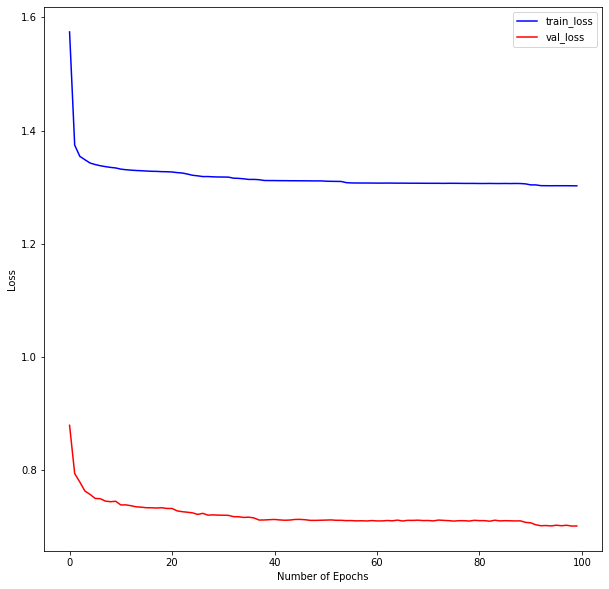

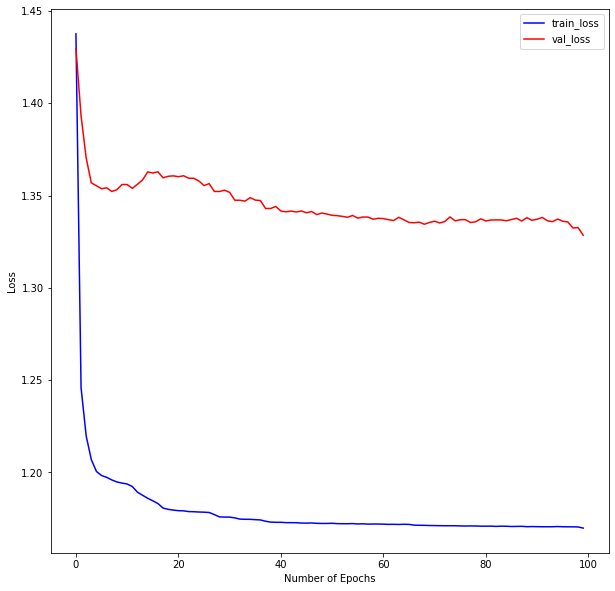

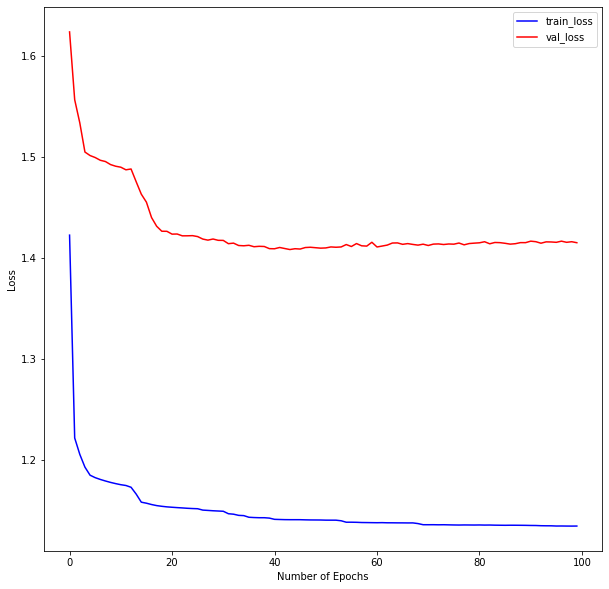

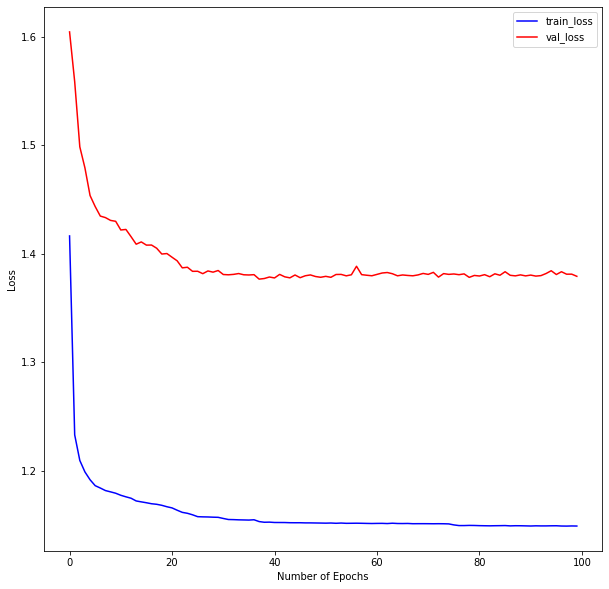

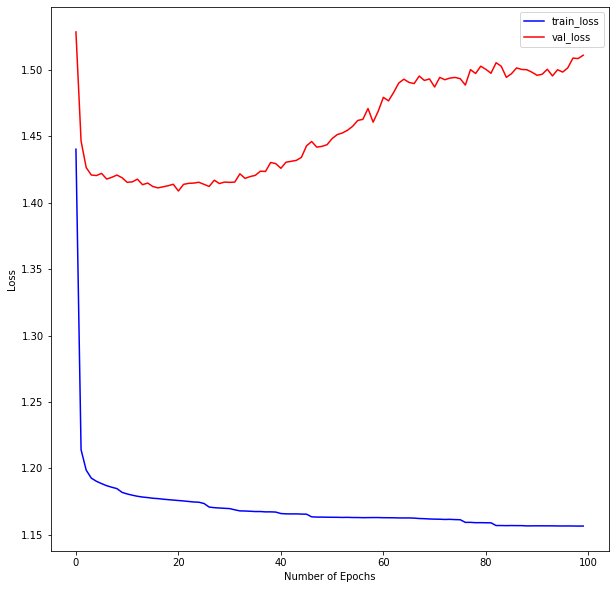

In [ ]:
k="sample"
path=f"/content/drive/MyDrive/{k}"
train(path,X1,X2)